In [5]:
!pip install gmplot
!pip install pyproj
!pip install mplstereonet
!pip install shapely
!pip install geopandas

grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.


In [6]:
# IMPORTANTE ATTENZIONE OCCORRE CONVERTIRE IL FILE DIINGRESSO DEI PUNTI
# IN COORDINATE PIANE METRICHE 

import pandas as pd
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from geopandas import GeoDataFrame
from __future__ import division
import mplstereonet
#from mpl_toolkits.basemap import pyproj
#from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform
###################################plotly_block###################################################### 
# Import plotly package online####################
import plotly
plotly.tools.set_credentials_file(username='davide.schenone', api_key='WBSgVI0FXgSIRecK2cHU')
import plotly.graph_objs as go
# Check ploltly version
plotly.__version__

#plotly offline###############
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #attivando o disattivando questa riga si ottiene un plot 
                                   #contestuale rispettivamente in notebook oppure su un html

# To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py
################################################################################################

from pandas import ExcelWriter
from pandas import ExcelFile
# Create data with x and y random over [-2, 2], and z a Gaussian function of x and y.
#np.random.seed(12345)
#x = 2 * (np.random.random(500) - 0.5)
#y = 2 * (np.random.random(500) - 0.5)

#def f(x, y):
 #   return np.exp(-(x + y ** 2))

#z = f(x, y)

#imposto i dati
#importa il file originale
#df = pd.read_csv('Saorge_Taggia_erh_erz_prof.csv', sep='\t', names=['y', 'x','z','a','b'])

#importa il file convertito con convergo
df = pd.read_excel('terremoti_santo.xlsx', sheet_name='Foglio1')


df['z'] = df['Prof corr']  #creo il campo z profondità con valori negativi


df['Data'] = df['Data'].astype(str).str.zfill(6) #riempie la mancanza dello zero nei primi valori
df['Data'] =  pd.to_datetime(df['Data'],  format='%y%m%d')
#df['Ora'] =  pd.to_time(df['Ora'],  format='%H%M')
#creo una colonna con  la differenza in giorni tra la data e una posta abbastanza indietro nel passato
df['Deltatime'] = df['Data'] - datetime.date(1989,1,1)
df['Deltatime'] = df['Deltatime'].astype(datetime.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

#converto le coordinate wgs 84 in UTM epsg 3003 Gauss-Boaga 
x1 = np.array(df['Longit.'])
y1 = np.array(df['Latitud.'])


inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3003')
x2,y2 = transform(inProj,outProj, x1, y1)

df['x'] = x2
df['y'] = y2

#con questo posso fare dei cluster temporali
#IMPOSTO I FILTRI

#df_filter = df.query('Erh<1 and Erz<4') #imposto i parametri di filtro sugli errori orizzontali e verticali


#df_filter = df.query('<Deltatime<') #imposto il filtro sulla data

#imposto i pesi per il calcolo del piano da utilizzare in caso di regressione lineare pesata

df['weight_calc'] = df['Nf']/24 - 0.25
def weight(df):
    if df['Nf'] <=6 :
        return 0
    
    elif  df['Nf'] > 6 and df['Nf']  < 30   :
        return df['weight_calc']
            
    elif  df['Nf'] >= 30 :
        return 1

df['weights'] =  df.apply(weight, axis=1) 
 

    
df_filter = df




In [7]:
df

,Data,Ora,Sec,Latitud.,Longit.,Prof.,Mag,Nf,Gap,Dst,Rms,Erh,Erz,Prof corr,z,Deltatime,x,y,weight_calc,weights
0,2002-10-06,1140,45.91,44.4433,9.5315,11.22,2,10,292,3,0.17,3.7,2.3,-11220.0,-11220.0,5026,1.542322e+06,4.921266e+06,0.166667,0.166667
1,2002-10-15,639,31.68,44.4702,9.5407,11.73,2,10,264,6,0.06,1.6,1.3,-11730.0,-11730.0,5035,1.543034e+06,4.924259e+06,0.166667,0.166667
2,2002-10-18,1526,57.12,44.5420,9.6360,15.38,2,6,325,24,0.04,4.2,3.9,-15380.0,-15380.0,5038,1.550553e+06,4.932289e+06,0.000000,0.000000
3,2004-08-02,1844,44.22,44.5515,9.4215,13.50,2,14,320,18,0.16,4.7,4.0,-13500.0,-13500.0,5692,1.533507e+06,4.933234e+06,0.333333,0.333333
4,2005-04-18,1104,16.00,44.7048,9.4235,5.51,2,30,163,33,0.30,1.3,1.9,-5510.0,-5510.0,5951,1.533577e+06,4.950264e+06,1.000000,1.000000
5,2006-11-28,1226,30.62,44.6158,9.3750,7.75,2,54,92,27,0.34,1.7,1.7,-7750.0,-7750.0,6540,1.529780e+06,4.940359e+06,2.000000,1.000000
6,2006-11-28,1227,20.15,44.6127,9.3763,6.00,2,36,100,18,0.38,1.4,0.8,-6000.0,-6000.0,6540,1.529885e+06,4.940015e+06,1.250000,1.000000
7,2006-11-28,1228,12.63,44.5870,9.3762,8.21,2,42,182,24,0.38,1.5,1.6,-8210.0,-8210.0,6540,1.529890e+06,4.937160e+06,1.500000,1.000000
8,2006-11-28,1320,25.37,44.6298,9.3868,9.81,2,58,88,16,0.32,0.5,0.7,-9810.0,-9810.0,6540,1.530709e+06,4.941918e+06,2.166667,1.000000
9,2007-07-11,843,48.70,44.5848,9.3112,11.71,2,74,74,23,0.34,0.9,1.0,-11710.0,-11710.0,6765,1.524732e+06,4.936894e+06,2.833333,1.000000


## Procedo con il PRIMO  clustering attraverso DBSCAN (BASE TEMPORALE)

In [8]:

coords = df_filter.as_matrix(columns=['Deltatime'])

from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=70, min_samples=10).fit(coords)
labels = db.labels_
from collections import Counter


df_filter = df_filter.assign(Classe = labels)
print(Counter(labels))
#filtro la label di interesse
df_cluster = df_filter[df_filter['Classe'] == labels]


#inserisco il valore K su cui far girare il ciclo FOR
cicli = df_filter['Classe'].value_counts().index.tolist()
cicli = np.array(cicli)
cicli_clean = np.delete(cicli, np.where(cicli == [-1]), axis=0)# cancello il label -1 che rappresente gli outliers
plot_dip_direction = []
plot_dip = []

plot_dip_direction_elips = []
plot_dip_elips = []

Counter({0: 62, -1: 61, 3: 42, 2: 25, 1: 19})


## Procedo con il SECONDO  clustering attraverso DBSCAN (BASE SPAZIALE)

##################################################
0 0
dip_direction= 52.389385 ; dip= 40.200088
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0]
-0.477212 x + -1.082230 y + 6056308.334206 = z
##################################################
0 0
dip_direction_elips= 23.795203 ; dip_elips= 49.786465
##################################################
0 0
dip_direction= 155.712948 ; dip= 40.256671
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0 1 2]
-0.567478 x + 0.844278 y + -3302495.466342 = z
##################################################
0 0
dip_direction_elips= 146.093151 ; dip_elips= 45.490462
##################################################
0 1
dip_direction= 331.488588 ; dip= 8.167217
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0 1 2]
0.086542 x + -0.137799 y + 540529.278786 = z
##################################################
0 1
dip_direction_elips= 327.869809 ; dip_elips= 9.242209
#########################################

-0.569325 x + -0.985566 y + 5732368.114474 = z
##################################################
3 1
dip_direction_elips= 30.013428 ; dip_elips= 48.697788
##################################################
3 0
dip_direction= 262.212362 ; dip= 31.813991
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0]
7.185288 x + 6.035765 y + -40829739.252390 = z
##################################################
3 0
dip_direction_elips= 229.969164 ; dip_elips= 83.917246
##################################################
3 0
dip_direction= 260.100613 ; dip= 31.349777
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0]
4.834943 x + 4.094075 y + -27636854.421577 = z
##################################################
3 0
dip_direction_elips= 229.743140 ; dip_elips= 81.030344
##################################################
3 0
dip_direction= 259.152222 ; dip= 39.741230
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0]
101.488729 x + 56.827431 y + -436352721.9315

1.589912 x + -0.036382 y + -2275506.670957 = z
##################################################
2 1
dip_direction_elips= 271.310883 ; dip_elips= 57.838270
##################################################
2 0
dip_direction= 4.058691 ; dip= 11.678339
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0 1]
-1.337342 x + -2.050490 y + 12165976.189839 = z
##################################################
2 0
dip_direction_elips= 33.112646 ; dip_elips= 67.780629
##################################################
2 1
dip_direction= 248.111905 ; dip= 32.575218
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0 1]
1.589912 x + -0.036382 y + -2275506.670957 = z
##################################################
2 1
dip_direction_elips= 271.310883 ; dip_elips= 57.838270
##################################################
2 0
dip_direction= 5.129518 ; dip= 11.760381
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [0 1]
-1.233735 x + -1.968992 y + 11604621.2862

0.170779 x + 0.420051 y + -2339907.703603 = z
##################################################
1 0
dip_direction_elips= 202.124981 ; dip_elips= 24.391479
##################################################
1 1
dip_direction= 202.763859 ; dip= 21.549907
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [1 0]
0.170779 x + 0.420051 y + -2339907.703603 = z
##################################################
1 1
dip_direction_elips= 202.124981 ; dip_elips= 24.391479
##################################################
1 0
dip_direction= 38.264620 ; dip= 59.425124
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [1 0]
-1.531471 x + -1.689454 y + 10681238.459758 = z
##################################################
1 0
dip_direction_elips= 42.191944 ; dip_elips= 66.320463
##################################################
1 1
dip_direction= 202.763859 ; dip= 21.549907
Controllo di aver eliminato scatter outlayer [-1] [0 3 2 1] [1 0]
0.170779 x + 0.420051 y + -2339907.70360

-1.530633 x + -1.704523 y + 10754260.933964 = z
##################################################
1 0
dip_direction_elips= 41.923310 ; dip_elips= 66.418292


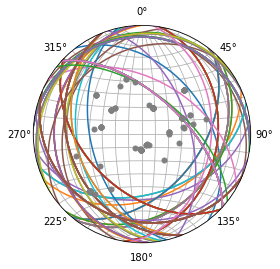

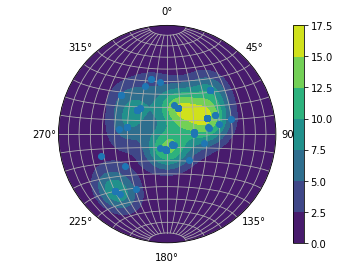

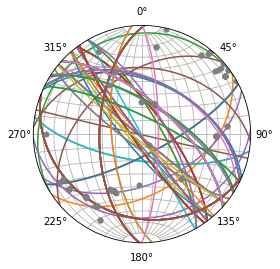

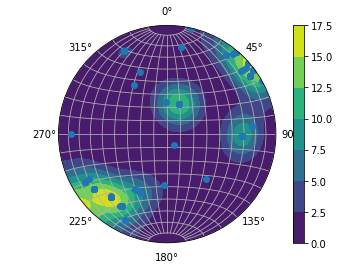

In [9]:
for K in cicli_clean:
    
    #filtro la label di interesse
    df_cluster = df_filter[df_filter['Classe'] == K]
    df_filter_2 = df_cluster
    coords_2 = df_cluster.as_matrix(columns=['x','y','z'])

    for distance in range (1000, 10000, 500):
        from sklearn.cluster import DBSCAN
        import numpy as np
        #base eps 3000 min_samples 5
        db = DBSCAN(eps=distance, min_samples=5).fit(coords_2)
        labels_2 = db.labels_
        from collections import Counter
        
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        import sys
        import numpy as np
        from numpy import linalg
        from random import random




        df_filter_2 = df_filter_2.assign(Classe_spaziale = labels_2)
    
        #inserisco il valore J su cui far girare il SECONDO ciclo FOR
        cicli_2 = df_filter_2['Classe_spaziale'].value_counts().index.tolist()
        cicli_2 = np.array(cicli_2)
        cicli_2_clean = np.delete(cicli_2, np.where(cicli_2 == [-1]), axis=0)# cancello il label -1 che rappresente gli outliers


 ##################### SECONDO CICLO ######################################   
    
    
        for J in cicli_2_clean:


            #filtro la label di interesse
            df_cluster_2 = df_filter_2[df_filter_2['Classe_spaziale'] == J]


            inizio = df_cluster_2.iloc[0,0] # setto la data inizio e fine del cluster
            fine = df_cluster_2.iloc[-1,0]


            #




            #importo il file depurato degli outlayer:
            #df = pd.read_csv('taggia_saorge_ripulita_outlier.csv', sep=',', names=['x', 'y','z'])

            x = df_cluster_2['x']  

            y = df_cluster_2['y']   

            z = df_cluster_2['z']

            W = df_cluster_2['weights']





            data = np.c_[x,y,z]

            # regular grid covering the domain of the data
            mn = np.min(data, axis=0)
            mx = np.max(data, axis=0)
            X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
            XX = X.flatten()
            YY = Y.flatten()

            # best-fit linear plane (1st-order)
            # applico i pesi

            A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
            L = data[:,2]
            AW = A * np.sqrt(W[:,np.newaxis]) # intermedi con pesi per  calcolo dei coefficienti
            LW = L * np.sqrt(W)               # intermedi con pesi per  calcolo dei coefficienti

            C,_,_,_ = scipy.linalg.lstsq(AW, LW)    # coefficients

            # evaluate it on grid
            Z = C[0]*X + C[1]*Y + C[2]
            x_s=data[:,0]
            y_s=data[:,1]
            z_s=data[:,2]

            ####################################################################################################
            #ricavo la direzione e l'immersione del piano attraverso l'equazione del piano e i coseni direttori

            A=C[0]
            B=C[1]
            C_=-1
            D=C[2]

            #calcolo E
            E=np.sqrt(A**2 + B**2 + 1)

            #calcolo i coseni
            cos_a = A/E

            cos_b = B/E

            cos_cp = C_/E


            cos_c = np.cos((np.pi/2) + np.arccos(C_/E))   


            #print(cos_a, cos_b, cos_c, cos_cp, cos_a_deg, cos_b_deg)


            #calcolo la direzione teta del vettore, il coseni direttori danno la direzione del vettore occorrre aggiungere 90°
            teta_primo = np.arctan(cos_a/cos_b)   #espresso in radianti
            teta_deg = (teta_primo*180)/np.pi 

            #calcolo della direzione della massima pendenza sul piano
            #dip_direction = teta_deg 

            #calcolo l'immersione dip angolo tra la verticale e il piano
            dip_vert = np.arcsin(-1*cos_c)
            dip_deg = (dip_vert*180)/np.pi

            #calcolo l'immersione dip
            dip = dip_deg

            #occorre orientare correttamente il dip_direction
            if cos_a > 0 and cos_b > 0:                
                dip_direction = teta_deg
                if cos_cp <0:
                    dip_direction =  dip_direction + 180

            if  cos_a > 0 and cos_b < 0:
                dip_direction = teta_deg + 180
                if cos_cp <0:
                    dip_direction =  dip_direction + 180


            if  cos_a < 0 and cos_b < 0:
                dip_direction = teta_deg + 180
                if cos_cp <0:
                    dip_direction =  dip_direction - 180


            if  cos_a < 0 and cos_b > 0:
                dip_direction =  teta_deg + 360
                if cos_cp <0:
                    dip_direction =  dip_direction - 180

            
             #creo l'arrai per il plotaggio su stereogramma
            plot_dip_direction = np.append(plot_dip_direction, dip_direction)
            plot_dip = np.append(plot_dip, dip)
            print('##################################################')
            print(K,J)
            print("dip_direction= %f ; dip= %f" % (dip_direction, dip))
            #print(cos_a, cos_b)

           
            print("Controllo di aver eliminato scatter outlayer [-1]" , cicli_clean , cicli_2_clean) 


            
            
            

            class EllipsoidTool:
                """Some stuff for playing with ellipsoids"""
                def __init__(self): pass

                def getMinVolEllipse(self, P=None, tolerance=0.01):
                    """ Find the minimum volume ellipsoid which holds all the points

                    Based on work by Nima Moshtagh
                    http://www.mathworks.com/matlabcentral/fileexchange/9542
                    and also by looking at:
                    http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
                    Which is based on the first reference anyway!

                    Here, P is a numpy array of N dimensional points like this:
                    P = [[x,y,z,...], <-- one point per line
                         [x,y,z,...],
                         [x,y,z,...]]

                    Returns:
                    (center, radii, rotation)

                    """
                    (N, d) = np.shape(P)
                    d = float(d)

                    # Q will be our working array
                    Q = np.vstack([np.copy(P.T), np.ones(N)]) 
                    QT = Q.T

                    # initializations
                    err = 1.0 + tolerance
                    u = (1.0 / N) * np.ones(N)

                    # Khachiyan Algorithm
                    while err > tolerance:
                        V = np.dot(Q, np.dot(np.diag(u), QT))
                        M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
                        j = np.argmax(M)
                        maximum = M[j]
                        step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
                        new_u = (1.0 - step_size) * u
                        new_u[j] += step_size
                        err = np.linalg.norm(new_u - u)
                        u = new_u

                    # center of the ellipse 
                    center = np.dot(P.T, u)

                    # the A matrix for the ellipse
                    A = linalg.inv(
                                   np.dot(P.T, np.dot(np.diag(u), P)) - 
                                   np.array([[a * b for b in center] for a in center])
                                   ) / d

                    # Get the values we'd like to return
                    U, s, rotation = linalg.svd(A)
                    radii = 1.0/np.sqrt(s)

                    return (center, radii, rotation)

                def getEllipsoidVolume(self, radii):
                    """Calculate the volume of the blob"""
                    return 4./3.*np.pi*radii[0]*radii[1]*radii[2]

                def plotEllipsoid(self, center, radii, rotation, ax=None, plotAxes=False, cageColor='b', cageAlpha=0.2):
                    """Plot an ellipsoid"""
                    make_ax = ax == None
                    if make_ax:
                        fig = plt.figure()
                        ax = fig.add_subplot(111, projection='3d')

                    u = np.linspace(0.0, 2.0 * np.pi, 100)
                    v = np.linspace(0.0, np.pi, 100)

                    # cartesian coordinates that correspond to the spherical angles:
                    x = radii[0] * np.outer(np.cos(u), np.sin(v))
                    y = radii[1] * np.outer(np.sin(u), np.sin(v))
                    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
                    # rotate accordingly
                    for i in range(len(x)):
                        for j in range(len(x)):
                            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

                    if plotAxes:
                        # make some purdy axes
                        axes = np.array([[radii[0],0.0,0.0],
                                         [0.0,radii[1],0.0],
                                         [0.0,0.0,radii[2]]])
                        # rotate accordingly
                        for i in range(len(axes)):
                            axes[i] = np.dot(axes[i], rotation)


                        # plot axes

                        for p in axes:    
                            X3 = np.linspace(-p[0], p[0], 100) + center[0]
                            Y3 = np.linspace(-p[1], p[1], 100) + center[1]
                            Z3 = np.linspace(-p[2], p[2], 100) + center[2]   



                    # plot ellipsoid

                    if make_ax:
                        plt.show()
                        plt.close(fig)
                        del fig

            if __name__ == "__main__":
                # make 100 random points
                #P = np.reshape([random()*100 for i in range(300)],(100,3))
                P=data #plotto i dati del piano

                # find the ellipsoid
                ET = EllipsoidTool()
                (center, radii, rotation) = ET.getMinVolEllipse(P, .01)
############################################################################################blocco elissoide
            import plotly.plotly as py
            import plotly.graph_objs as go

            import numpy as np

            trace1 = go.Scatter3d(
                x=x_s,
                y=y_s,
                z=z_s,
                mode='markers', marker=dict(size=4, color='red', line=dict(color='black', width=0.5),showscale=False, opacity=0.85)
            )

            trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu',showscale=False, opacity=0.9)
            plane_best_fit = trace2





            ######codice per plot elissoide
            u = np.linspace(0.0, 2.0 * np.pi, 100)
            v = np.linspace(0.0, np.pi, 100)

            # cartesian coordinates that correspond to the spherical angles:
            x_e = radii[0] * np.outer(np.cos(u), np.sin(v))
            y_e = radii[1] * np.outer(np.sin(u), np.sin(v))
            z_e = radii[2] * np.outer(np.ones_like(u), np.cos(v))
            for i in range(len(x_e)):
                for j in range(len(x_e)):
                    [x_e[i,j],y_e[i,j],z_e[i,j]] = np.dot([x_e[i,j],y_e[i,j],z_e[i,j]], rotation) + center
            surface = go.Surface(x=x_e, y=y_e, z=z_e,opacity=0.6,colorscale='Viridis')        


            ################################
            #codice per plottare gli assi
            # make some purdy axes
            ################################    

            axes = np.array([[radii[0],0.0,0.0],
                            [0.0,radii[1],0.0],
                            [0.0,0.0,radii[2]]])
                        # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)

            arr_x = []
            arr_y = []
            arr_z = []
            for p_ in axes:    
                X3 = np.linspace(-p_[0], p_[0], 100) + center[0]
                Y3 = np.linspace(-p_[1], p_[1], 100) + center[1]
                Z3 = np.linspace(-p_[2], p_[2], 100) + center[2]   
                arr_x.append(X3) 
                arr_y.append(Y3)
                arr_z.append(Z3)
            ########################################################



            asse_c = go.Scatter3d(
            x=arr_x[0] , y=arr_y[0], z=arr_z[0],mode='lines',
            line=dict(
                color='blue',showscale=False,
                width=4
            ))  

            asse_b = go.Scatter3d(
            x=arr_x[1] , y=arr_y[1], z=arr_z[1],mode='lines',
            line=dict(
                color='blue',showscale=False,
                width=4
            ))                

            asse_a = go.Scatter3d(
            x=arr_x[2] , y=arr_y[2], z=arr_z[2],mode='lines',
            line=dict(
                color='blue',showscale=False,
                width=4))

           

      ####################################################################      #########bloccopiano ed elissoide + stereonet
            
            #calcolo i punti del piano ac   tieni presente che sono i punti dei relativi assi dell'elissoide
            arr_ab_x=np.append(arr_x[2],arr_x[1],axis=0)
            arr_ab_y=np.append(arr_y[2],arr_y[1],axis=0)
            arr_ab_z=np.append(arr_z[2],arr_z[1],axis=0)

            arr_ab= np.array([arr_ab_x,arr_ab_y,arr_ab_z])
            arr_ab = np.transpose(arr_ab)


            #utilizzo lo script di interpolazione del piano  per calcolarne la relativa equazione


            A = np.c_[arr_ab[:,0], arr_ab[:,1], np.ones(arr_ab.shape[0])]
            L = arr_ab[:,2]

            C,_,_,_ = scipy.linalg.lstsq(A, L)    # coefficients

            # evaluate it on grid
            Z = C[0]*X + C[1]*Y + C[2]
            print("%f x + %f y + %f = z" % (C[0], C[1], C[2]))



            #ricavo la direzione e l'immersione del piano attraverso l'equazione del piano e i coseni direttori

            A=C[0]
            B=C[1]
            C_=-1
            D=C[2]

            #calcolo E
            E=np.sqrt(A**2 + B**2 + 1)

            #calcolo i coseni
            cos_a = A/E

            cos_b = B/E

            cos_cp = C_/E  #gamma_p


            cos_c = np.cos((np.pi/2) + np.arccos(C_/E))   #controllare se è corretto 

            #calcolo la direzione teta del vettore, il coseni direttori danno la direzione del vettore occorrre aggiungere 90°
            teta_primo = np.arctan(cos_a/cos_b)   #espresso in radianti
            teta_deg = (teta_primo*180)/np.pi 

            #calcolo della direzione della massima pendenza sul piano
            #dip_direction = teta_deg 

            #calcolo l'immersione dip angolo tra la verticale e il piano
            dip_vert = np.arcsin(-1*cos_c)
            dip_deg = (dip_vert*180)/np.pi
           
            #calcolo l'immersione dip
            dip_elips = dip_deg
            #occorre orientare correttamente il dip_direction
            #cond_1 = dip_direction = teta_deg
            #cond_2 = dip_direction = teta_deg + 180
            #cond_3 = dip_direction =  teta_deg + 360
            
            #def orientation(cos_a,cos_b):
            
            if cos_a > 0 and cos_b > 0:                
                dip_direction_elips = teta_deg
                if cos_cp <0:
                    dip_direction_elips =  dip_direction_elips + 180

            if  cos_a > 0 and cos_b < 0:
                dip_direction_elips = teta_deg + 180
                if cos_cp <0:
                    dip_direction_elips =  dip_direction_elips + 180


            if  cos_a < 0 and cos_b < 0:
                dip_direction_elips = teta_deg + 180
                if cos_cp <0:
                    dip_direction_elips =  dip_direction_elips - 180


            if  cos_a < 0 and cos_b > 0:
                dip_direction_elips =  teta_deg + 360
                if cos_cp <0:
                    dip_direction_elips =  dip_direction_elips - 180



            #########################

            #creo l'array per il plotaggio su stereogramma
            
            

            plot_dip_direction_elips = np.append(plot_dip_direction_elips, dip_direction_elips)
            plot_dip_elips = np.append(plot_dip_elips, dip_elips)
            print('##################################################')
            print(K,J)
            print("dip_direction_elips= %f ; dip_elips= %f" % (dip_direction_elips, dip_elips))
            #print(cos_a, cos_b)


            



        
        
        
        
        
       
#crea gli stereogrammi
strike = plot_dip_direction - 90 
dip =  plot_dip
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip)
ax.pole(strike, dip ,markersize=5)
ax.grid()
plt.show()

#density plot
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(strike, dip, measurement='poles')
ax.pole(strike, dip)
ax.grid(True)
fig.colorbar(cax)




##########################plot elipsoid
strike = plot_dip_direction_elips - 90
dip =  plot_dip_elips
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip)
ax.pole(strike, dip ,markersize=5)
ax.grid()
plt.show()

#density plot
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(strike, dip, measurement='poles')
ax.pole(strike, dip)
ax.grid(True)
fig.colorbar(cax)

plt.show()